# Equitable Sales Region Division in Jeddah Using Geospatial Analysis

In [ ]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.path.dirname("__init__.py"), ".."))
sys.path.insert(0, parent_dir)

import pandas as pd
from salse_man_problem import *

## Introduction

In this analysis, we address a common problem in sales territory management: how to divide a city into equitable regions so that each salesman gets an equal market share. The challenge arises when considering both the population distribution and supermarket locations, as neither factor alone ensures fairness.

Jeddah, our region of interest, has the following statistics:

- **Total Population:** 3.18 Million
- **Male Percentage:** 60.11%
- **Female Percentage:** 39.86%
- **Total Supermarkets:** 681

Our goal is to divide Jeddah into sales regions that balance both consumer demand and supermarket access.

In [9]:
population_data = pd.read_csv("../population.csv")
places_data = pd.read_json("../saudi_supermarkets_20250218_121912.json")
bounding_box = [(38.936119, 21.880214),
                (39.221764, 21.903151),
                (39.457970, 21.005913),
                (39.092674, 20.998221)]

population = get_population_by_zoom_in_bounding_box(population_data=population_data, 
                                                        zoom_level=5, 
                                                        bounding_box=bounding_box)

places = get_places_data(places_data=places_data, 
                            bounding_box=bounding_box).assign(longitude=lambda x: x.geometry.x,
                                                                latitude=lambda x: x.geometry.y)

x = population[["population", "male_population", "female_population", "median_age_male", "median_age_female", "household_average_size"]]
print("Total Population", np.round(x.population.sum()/1e6, 2), "Million")
print("Male Percentage", np.round(x.male_population.sum() / x.population.sum() * 100, 2), "%")
print("Female Percentage", np.round(x.female_population.sum()/ x.population.sum() * 100, 2), "%")
print("Total supermarkets", places.geometry.drop_duplicates().shape[0])

Total Population 3.18 Million
Male Percentage 60.11 %
Female Percentage 39.86 %
Total supermarkets 681


## Problem Statement

A company has multiple salesmen, each assigned a specific region within the city. If we divide the city based on population alone without considering supermarket locations, some sales regions may be underserved. Conversely, dividing solely based on supermarkets ignores consumer demand.

To achieve an equitable division, we introduce a metric that accounts for both factors: **effective population per supermarket**. This ensures that each salesman gets a region with a fair market share.


## Methodology

### Step 1: Calculate Supermarket Accessibility

The first step is to determine how many supermarkets are accessible from each population center. We define accessibility based on three distance thresholds:

- **1 km**: Represents walkable access.
- **5 km**: Represents short driving access.
- **10 km**: Represents extended reach.

This requires calculating an **origin-destination distance matrix**, where each origin is a population center and each destination is a supermarket.

### Step 2: Compute Market Share

Once the distance matrix is computed, we invert it to determine how many population centers can access each supermarket. Using this data, we calculate the market share of each supermarket as follows:

#### Mathematical Formulation

For a given population center *i*:

$$
ef_i = \frac{P_i}{S_i}
$$

**Where:**

- $ef_i$ = Effective population for population center *i*
- $P_i$ = Population of center *i*
- $S_i$ = Number of supermarkets accessible from center *i*

For a given supermarket *j*:

$$
ms_j = \sum ef_{ij} \quad \text{for all centers that can access supermarket } j
$$

**Where:**

- $ms_j$ = Market share of supermarket *j*
- $ef_{ij}$ = Effective population from all population centers *i* accessing supermarket *j*

### Assumptions

To simplify the analysis, we make the following assumptions:

1. Consumer demand is evenly distributed across the region.
2. All supermarkets provide the same range of products.
3. Salesmen cover their designated areas without overlap.

### Step 3: Clustering for Equitable Sales Regions

Once the market share is computed, we use **clustering algorithms**  to divide Jeddah into sales regions. The key difference in our approach is that **market share**, not population density or geographical area, is the basis for clustering.

In [6]:
data_1k_distance = get_clusters_for_sales_man(num_sales_man=8, 
                                  population=population_data, 
                                  places=places_data, 
                                  bounding_box=bounding_box, 
                                  distance_limit=1,
                                  zoom_level=5)


data_5k_distance = get_clusters_for_sales_man(num_sales_man=8, 
                                  population=population_data, 
                                  places=places_data, 
                                  bounding_box=bounding_box, 
                                  distance_limit=5,
                                  zoom_level=5)

data_10k_distance = get_clusters_for_sales_man(num_sales_man=8, 
                                  population=population_data, 
                                  places=places_data, 
                                  bounding_box=bounding_box, 
                                  distance_limit=10,
                                  zoom_level=5)

Case where supermartes are visited within 1km only


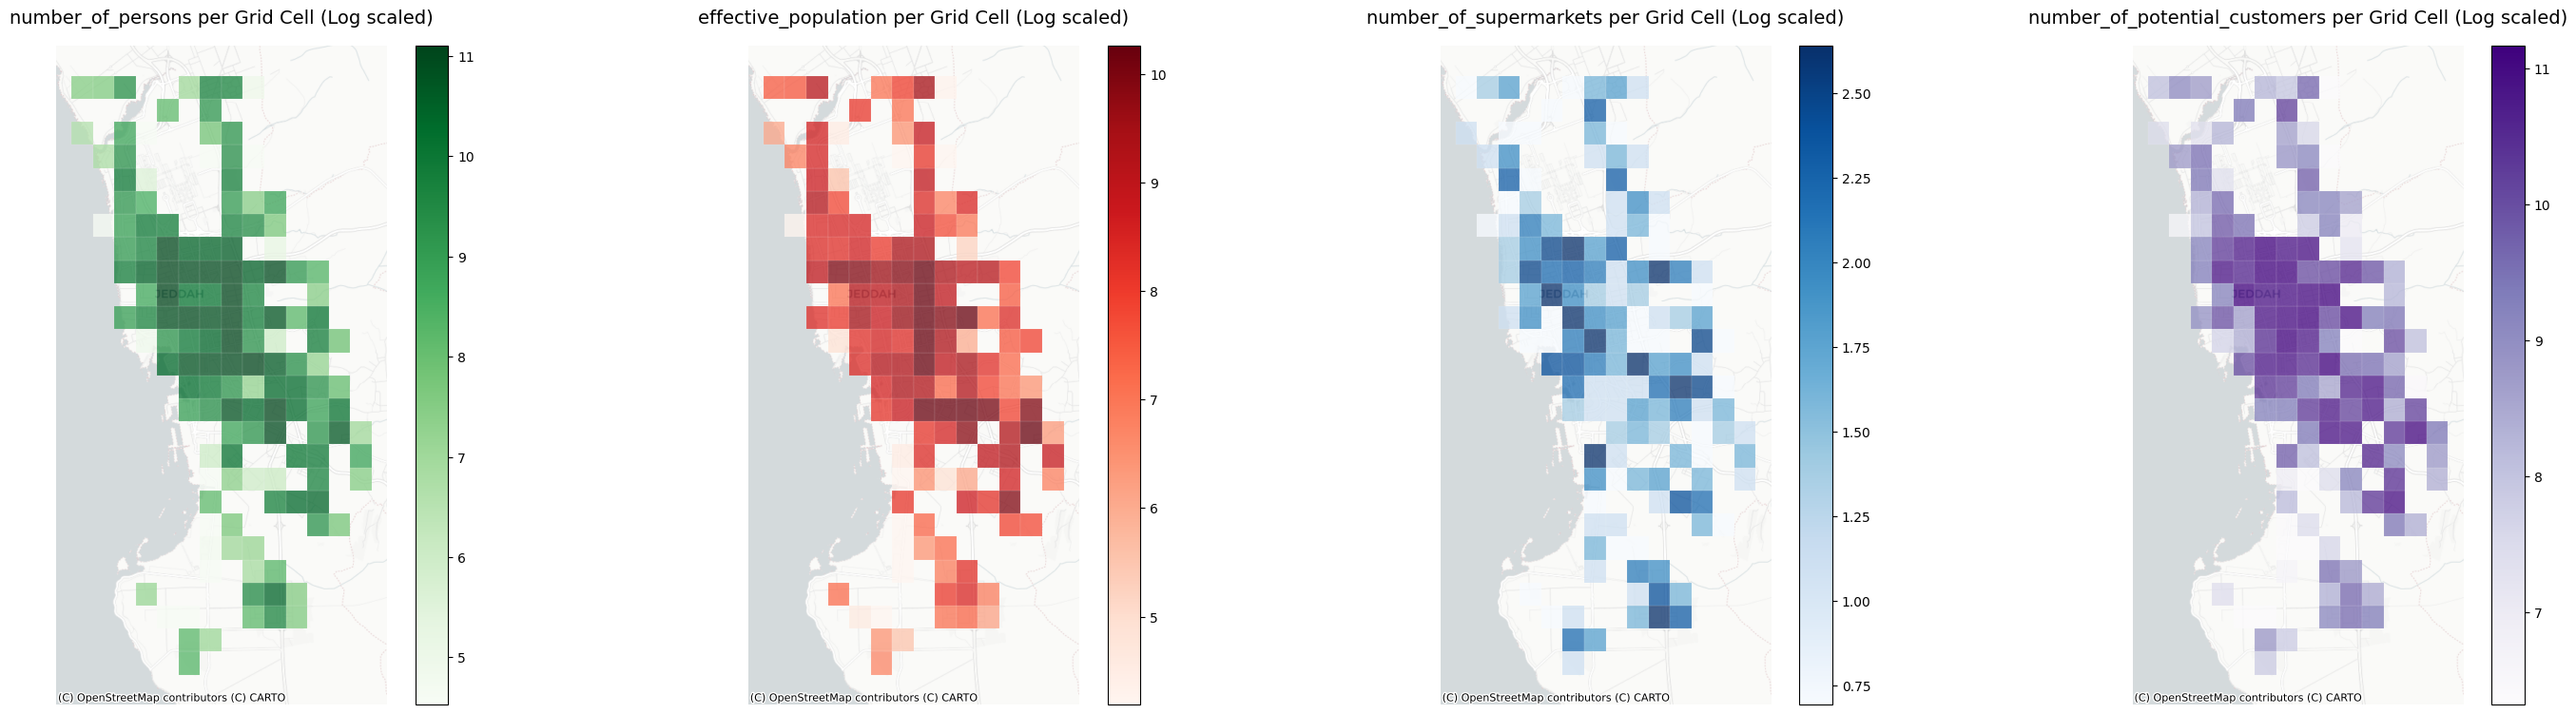

Case where supermartes are visited within 5km only


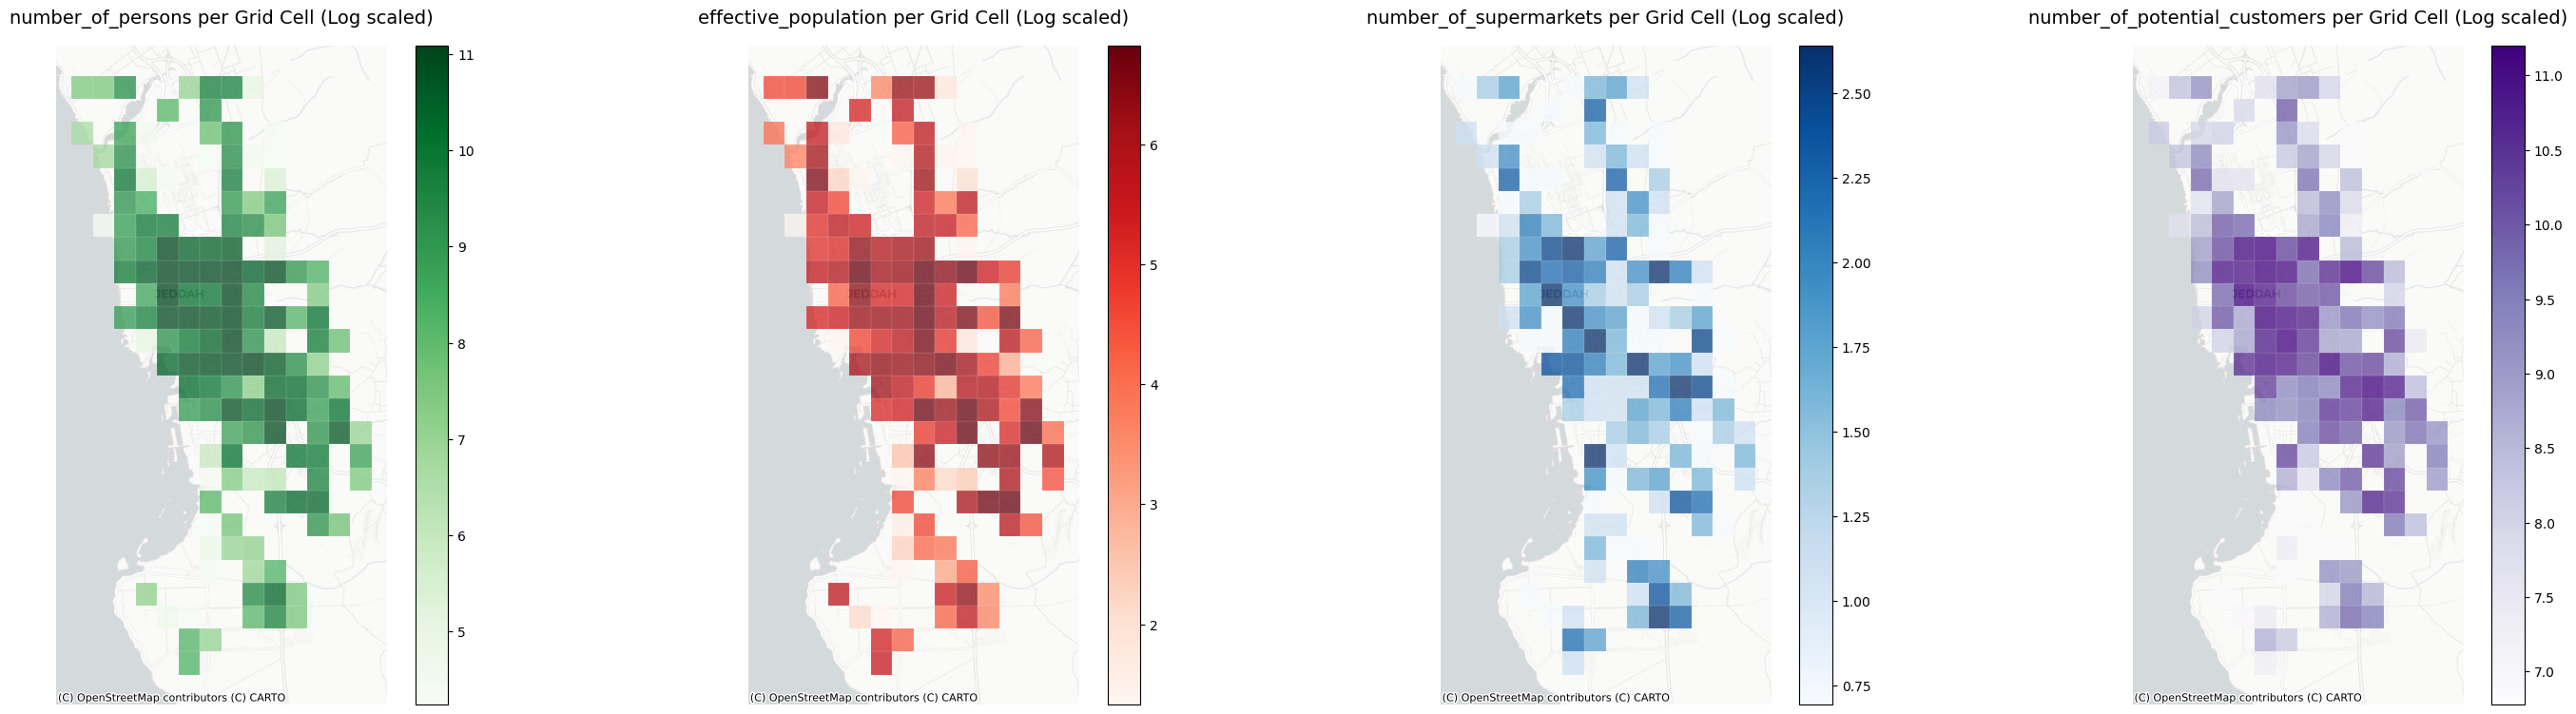

Case where supermartes are visited within 10km only


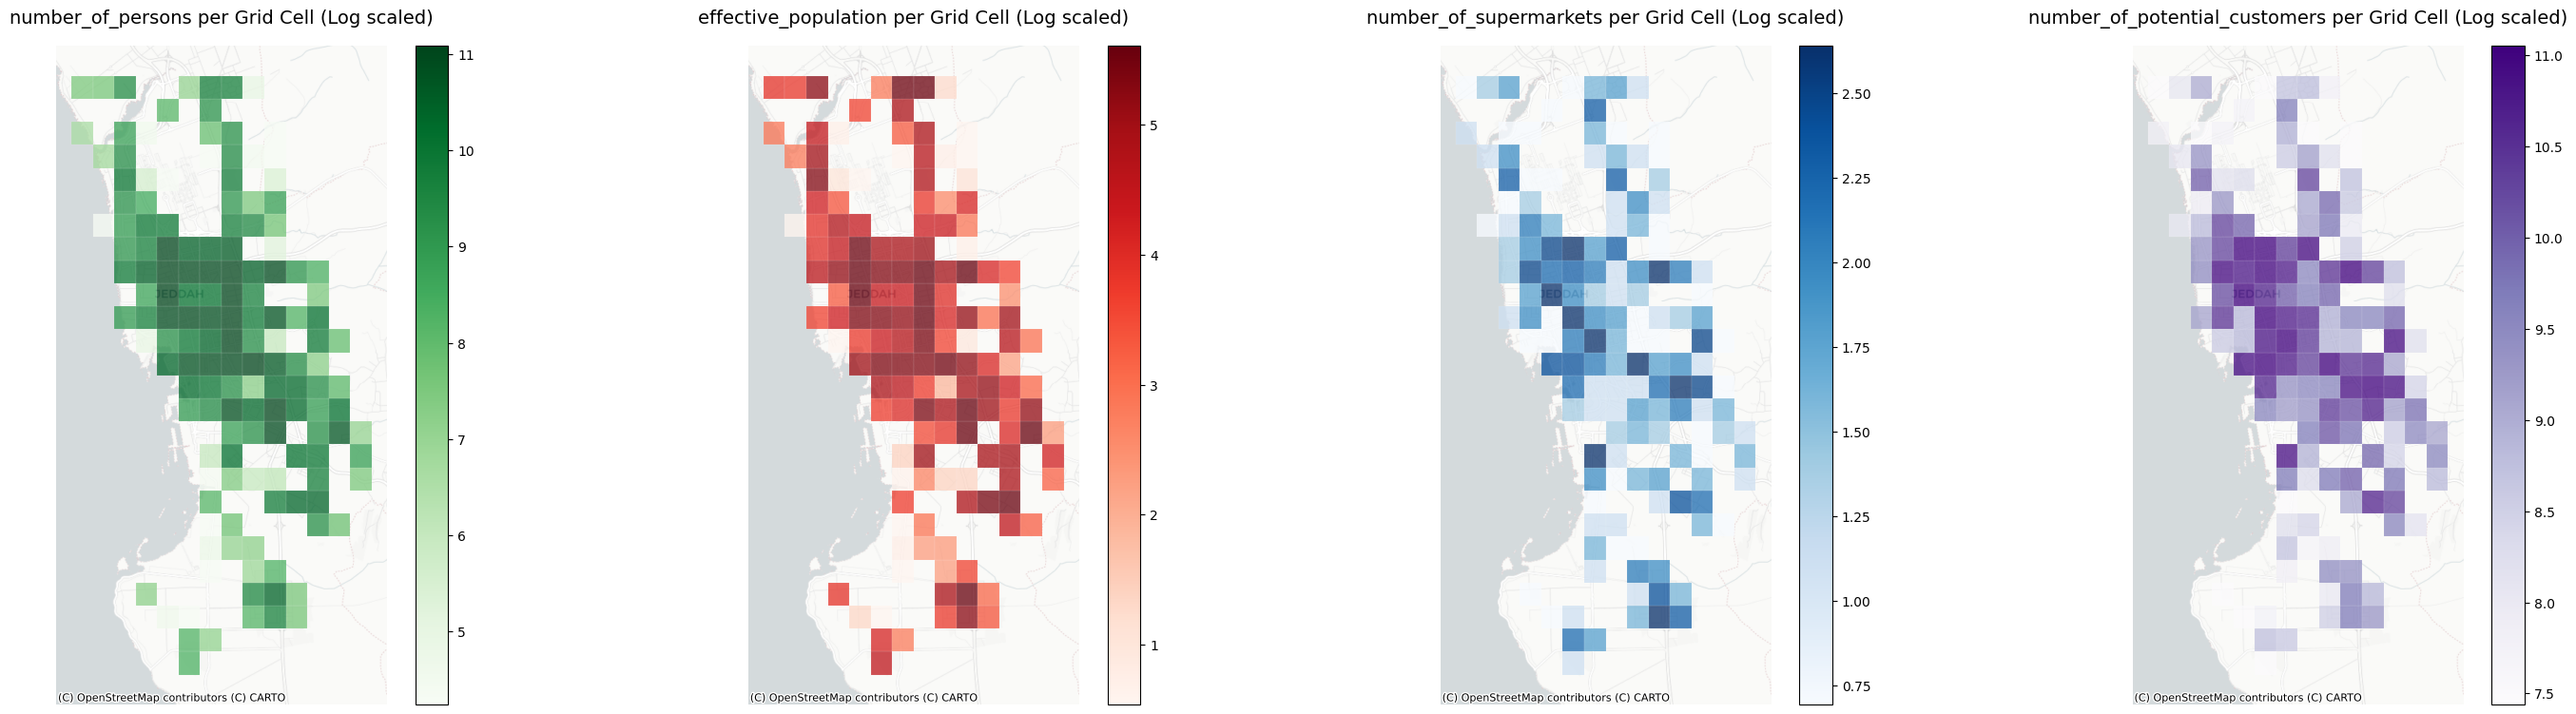

In [14]:
print("Case where supermartes are visited within 1km only")
plot_results(data_1k_distance.iloc[:,:-1], 4, 1, ["Greens", "Reds", "Blues", "Purples"], alpha=0.75)
print("Case where supermartes are visited within 5km only")
plot_results(data_5k_distance.iloc[:,:-1], 4, 1, ["Greens", "Reds", "Blues", "Purples"], alpha=0.75)
print("Case where supermartes are visited within 10km only")
plot_results(data_10k_distance.iloc[:,:-1], 4, 1, ["Greens", "Reds", "Blues", "Purples"], alpha=0.75)

## Results and Insights

Our clustering results show that changing the maximum distance threshold for supermarket accessibility slightly impacts region boundaries. Notably:

- The **most populous areas** experience major boundary shifts as supermarket access varies.
- **Sparsely populated areas** remain largely unaffected by distance thresholds, as they have fewer supermarkets and a lower population density.

## Conclusion

This analysis provides a fair way to divide sales regions based on consumer demand and supermarket access. By using effective population as a metric, businesses can ensure their sales teams operate in regions with equitable market opportunities, leading to improved efficiency and profitability.

---



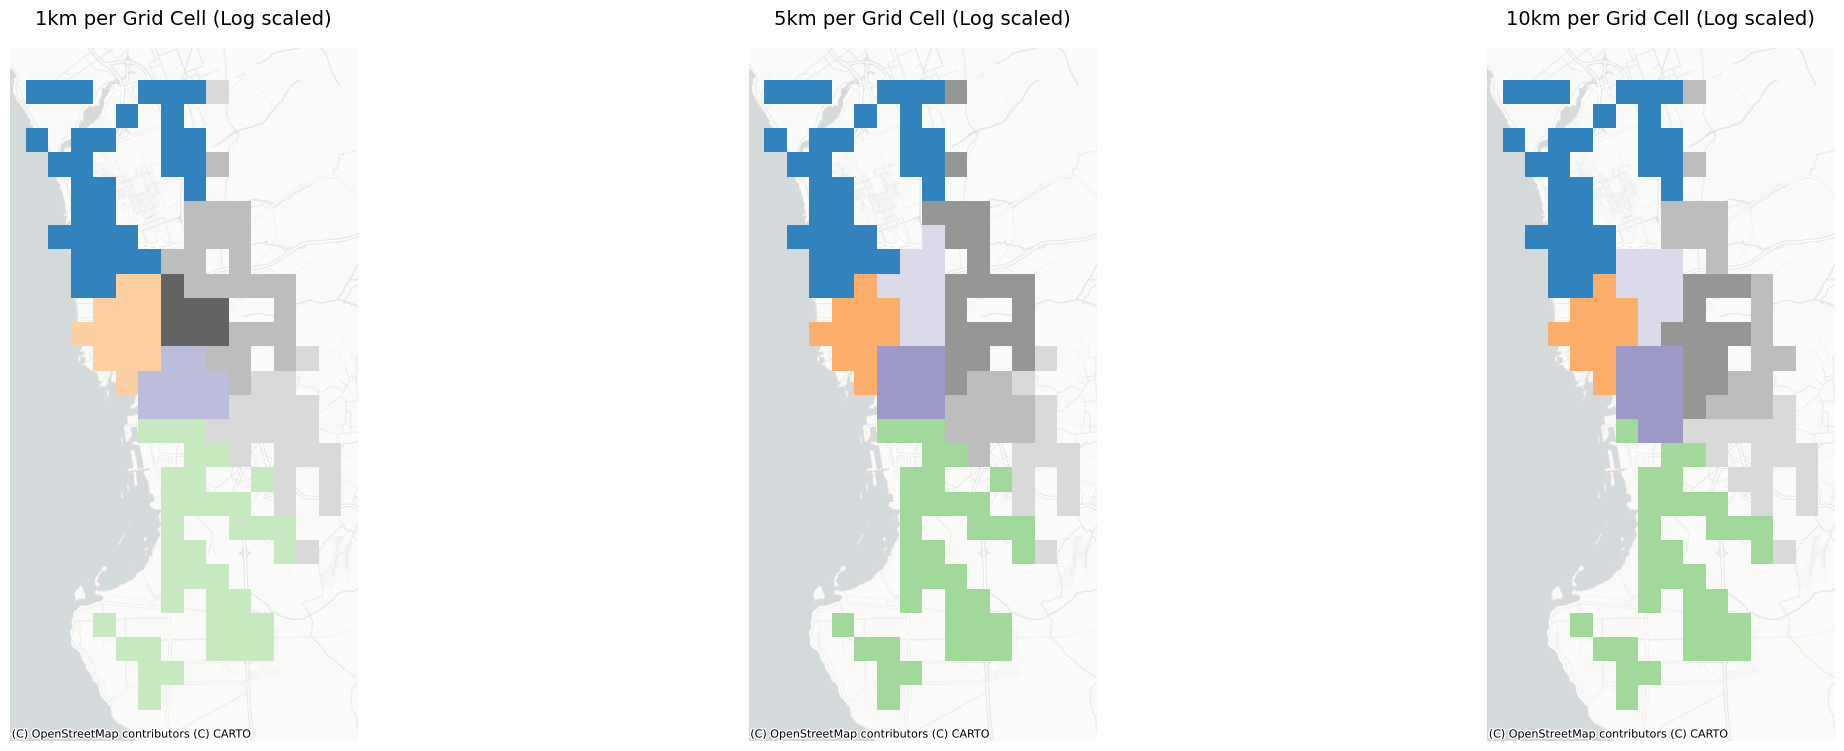

In [28]:
groups = pd.concat([
    data_1k_distance[["geometry", "group"]].rename(columns={"group": "1km"}).set_index("geometry"),
    data_5k_distance[["geometry", "group"]].rename(columns={"group": "5km"}).set_index("geometry"),
    data_10k_distance[["geometry", "group"]].rename(columns={"group": "10km"}).set_index("geometry")
], axis=1).reset_index(drop=False).dropna()

groups = gpd.GeoDataFrame(groups)

plot_results(groups, 3, 1, ["tab20c", "tab20c", "tab20c"], alpha=1, show_legends=False, edge_color=None, show_title=True)
